In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import wrangle
import explore

import warnings
warnings.filterwarnings("ignore")

# Notebook for documenting Zillow project data preparation and exploration work:
- Goal is to predict home value (tax_value)
- Initially just using number of bedrooms, bathrooms, and square footage to predict
- Drop outliers and nulls

## Once MVP complete, additional items to test:
- Imputing nulls (mean, median, or maybe based on bedroom and bathroom number) 
- Additional features from database
- Outlier handling:
    - Using RobustScaler or QuatileScaler to include outliers
    - Removing outliers by train, validate, test sets and not just the whole dataset
    - Including outliers
- Additional features to add and engineer
- Feature selection


In [2]:
df = wrangle.wrangle_zillow()

Using cached data


In [3]:
df.shape

(52442, 10)

In [4]:
df.isna().sum()

bedroom            0
bathroom           0
square_feet       82
tax_value          1
fips               0
garage             0
yearbuilt        116
condition      18701
zip               26
pool               0
dtype: int64

In [5]:
# Make column for home age
df["age"] = 2017 - df.yearbuilt

In [6]:
# Make a column for living space. Average bathroom is 40 sq ft, average bedroom is 200 sq ft
df["living_space"] = df.bathroom*40 + df.bedroom*200

In [7]:
df[df.fips == 6111.0].pool.value_counts(dropna=False)

0.0    3494
1.0     901
Name: pool, dtype: int64

In [8]:
# Convert bedrooms to integer type
# df.bedroom = df.bedroom.astype('int')

# Univariate exploration

### Box Plots

In [9]:
features_to_plot = ['bedroom', 'bathroom', 'square_feet', 'tax_value', 'living_space','age']

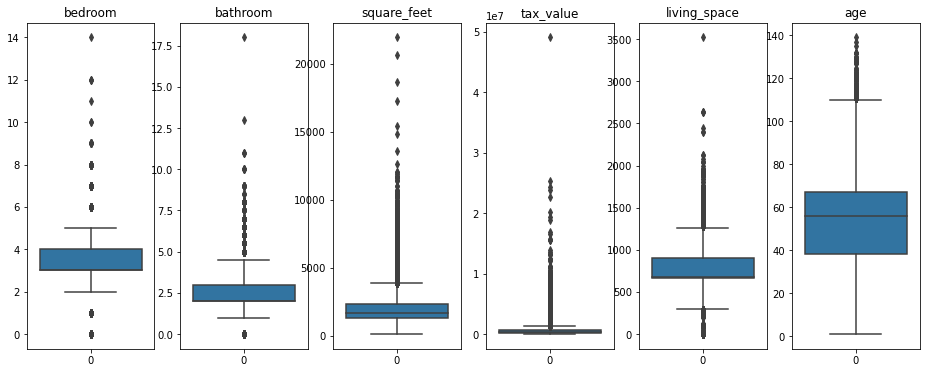

In [10]:
explore.plot_boxplots(df, features_to_plot)

## Takeaways:
- Some outliers for bedroom and bathroom but for the most part clustered between 2-4
- Lots of square footage outliers
- Very high outliers for tax value makes it difficult to visualize the lower end of home values, where most observations look to be

### Histograms

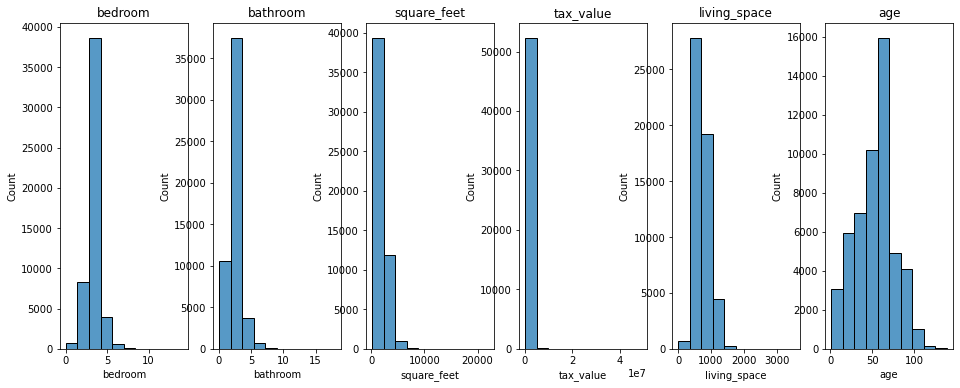

In [11]:
explore.plot_histograms(df, features_to_plot)

## Takeaways:
- Fairly normal distribution for bedroom and bathroom
- Square footage and tax_value look very skewed to the left due to some very high outliers

### Will drop outliers going forward for this MVP

In [12]:
# using a setting of 3 to keep as much data as possible
# df_outlier_removed = wrangle.remove_outliers(df, 3, ['bathroom','bedroom','square_feet', 'tax_value','age'])
df_outlier_removed = wrangle.remove_outliers(df, 3, ['tax_value'])

Number of observations removed: 1562


In [13]:
df_outlier_removed.shape

(50880, 12)

In [14]:
# df_outlier_removed = df_outlier_removed.dropna()

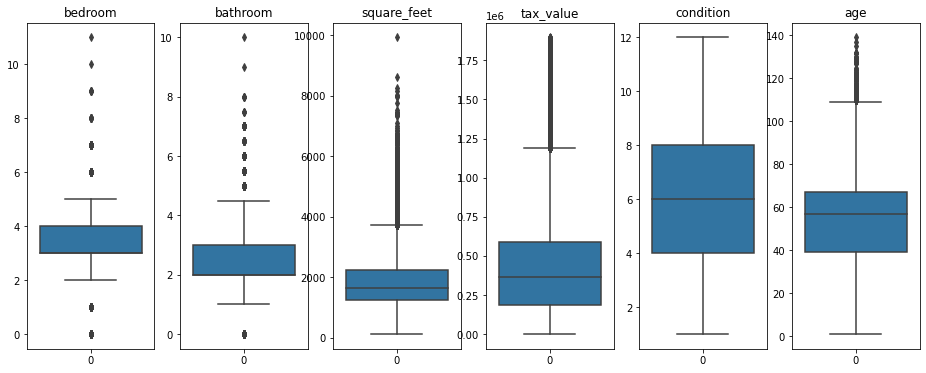

In [15]:
explore.plot_boxplots(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value','condition','age'])

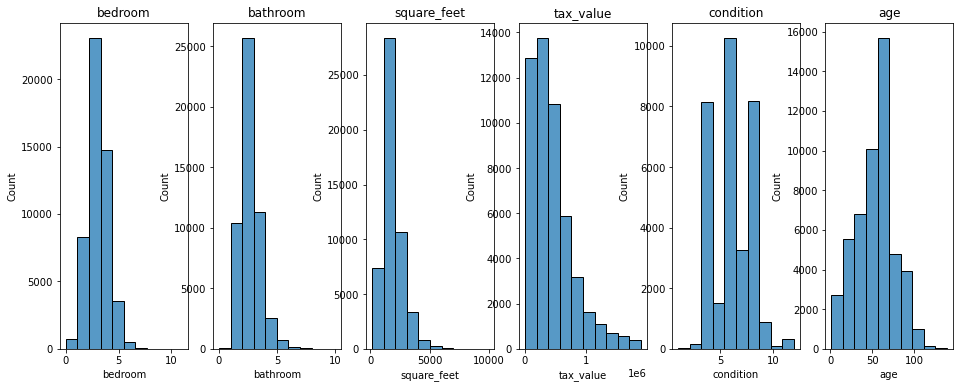

In [16]:
explore.plot_histograms(df_outlier_removed, ['bedroom', 'bathroom', 'square_feet', 'tax_value','condition','age'])

### With outliers removed:
- Relatively normal distributions for bedrooms, bathrooms, and square feet
- Left skewed for tax_value

In [17]:
df_outlier_removed.fips.value_counts()

6037.0    32844
6059.0    13690
6111.0     4346
Name: fips, dtype: int64

In [18]:
df_outlier_removed.shape

(50880, 12)

### Condition data

In [19]:
# Condition data only available for fips 6037.0. Will be dropping nans going forward but do not want to drop every row from other fips.
df_outlier_removed.condition = df_outlier_removed.condition.fillna(0)

### Garage data

In [20]:
df_outlier_removed[df_outlier_removed.fips == 6111.0].garage.value_counts(dropna=False)

2.0     3540
1.0      481
3.0      177
0.0       73
4.0       60
5.0        9
6.0        4
7.0        1
13.0       1
Name: garage, dtype: int64

### no garage data for fips 06037

In [21]:
# For MVP will just drop rows with NA. For the df with outliers removed this represents 55 rows of 50669 or <0.2%
df = df_outlier_removed.dropna()


In [22]:
df.shape

(50770, 12)

### Property locations

In [23]:
def get_locations_from_fips(fip):
    if int(fip) == 6037:
        return "Los Angeles County"
    if int(fip) == 6059:
        return "Orange County"
    if int(fip) == 6111:
        return "Ventura County"

In [24]:
df["county"] = df.fips.apply(lambda x: get_locations_from_fips(x))

In [25]:
df.county.value_counts()

Los Angeles County    32808
Orange County         13654
Ventura County         4308
Name: county, dtype: int64

## Splitting data going forward to explore multivariate relationships

In [26]:
train, validate, test = wrangle.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [27]:
train.shape

(28431, 13)

In [28]:
train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'pool', 'age', 'living_space',
       'county'],
      dtype='object')

#### Adding columns to simplify bedroom and bathroom counts as categoricals:
- Bedrooms: 3, more than 3, 2 or less
- Bathrooms: 2, more than 2, less than 2

#### Adding column to categorize whether a house has a garage or not

In [29]:
def bedroom_mapper(num):
    """ Map the number of bedrooms to a categorical label """
    if num <= 2:
        return "2_or_less"
    elif num <=3:
        return "3"
    elif num > 3:
        return "more_than_3"

In [30]:
def bathroom_mapper(num):
    """ Map the number of bathrooms to a categorical label """
    if num == 2:
        return "2"
    elif num < 2:
        return "less_than_2"
    elif num > 2:
        return "more_than_2"

In [31]:
# Applying this feature to all data sets
train["bedroom_cat"] = train.bedroom.apply(lambda row: bedroom_mapper(row))
validate["bedroom_cat"] = validate.bedroom.apply(lambda row: bedroom_mapper(row))
test["bedroom_cat"] = test.bedroom.apply(lambda row: bedroom_mapper(row))

In [32]:
train["bathroom_cat"] = train.bathroom.apply(lambda row: bathroom_mapper(row))
validate["bathroom_cat"] = validate.bathroom.apply(lambda row: bathroom_mapper(row))
test["bathroom_cat"] = test.bathroom.apply(lambda row: bathroom_mapper(row))

In [33]:
train["has_garage"] = np.where(train.garage>0, True, False)
validate["has_garage"] = np.where(validate.garage>0, True, False)
test["has_garage"] = np.where(test.garage>0, True, False)

Generating plots tax_value by bedroom_cat


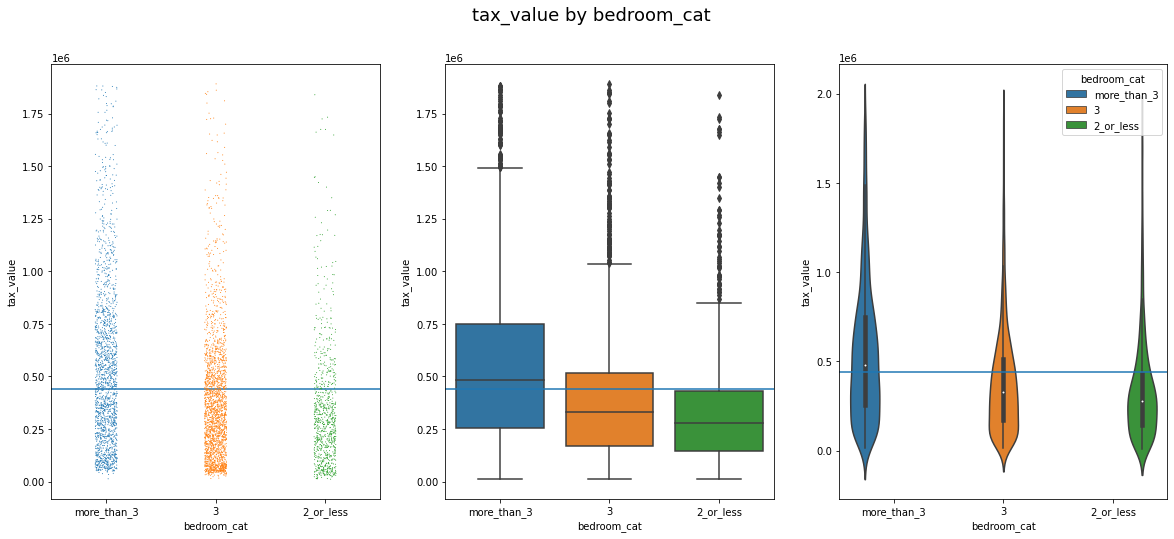

Generating plots tax_value by bathroom_cat


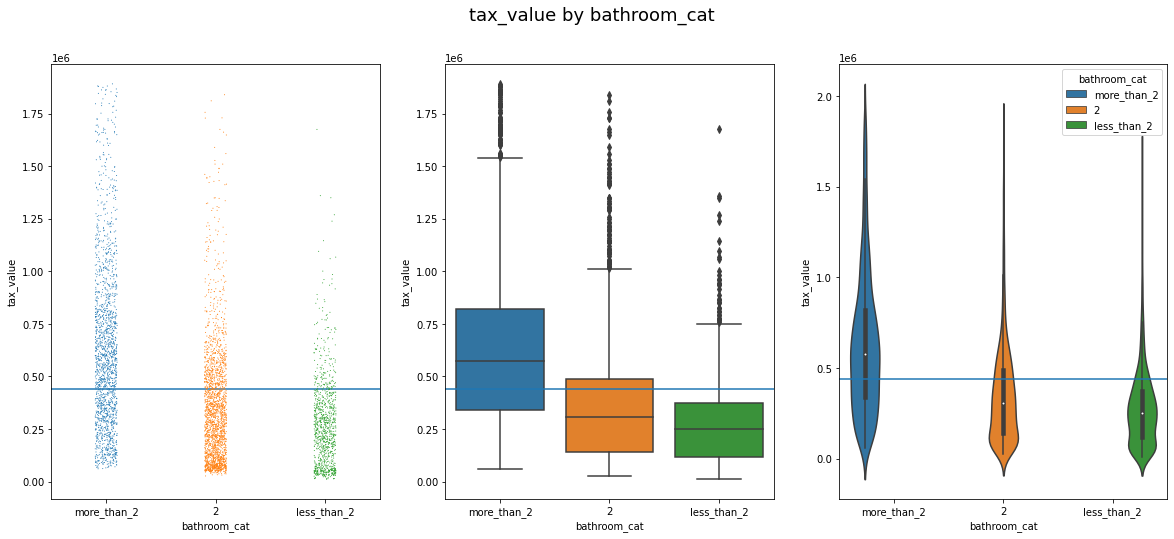

Generating plots tax_value by county


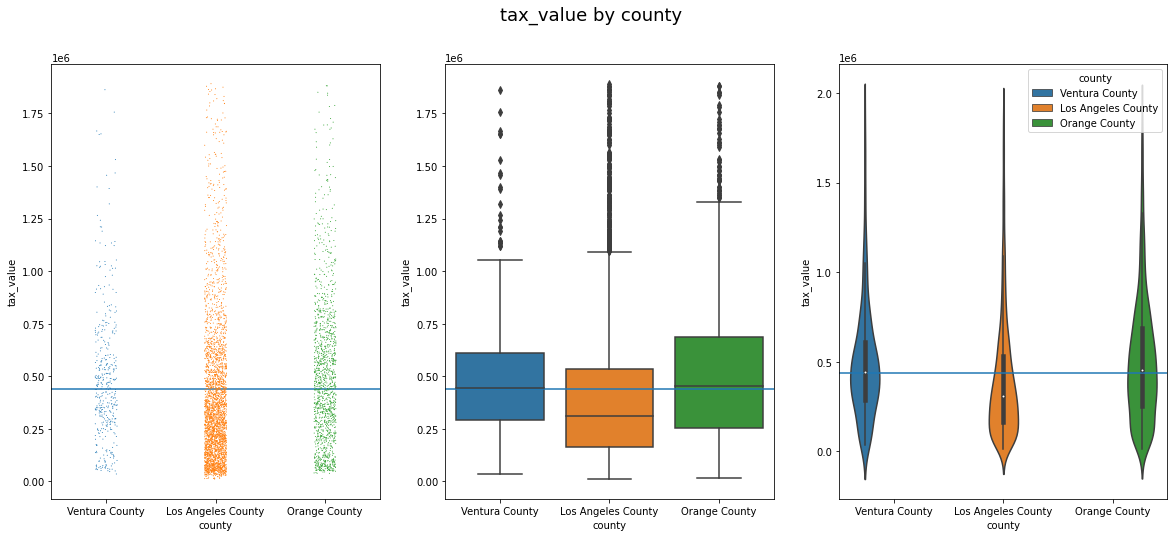

Generating plots tax_value by pool


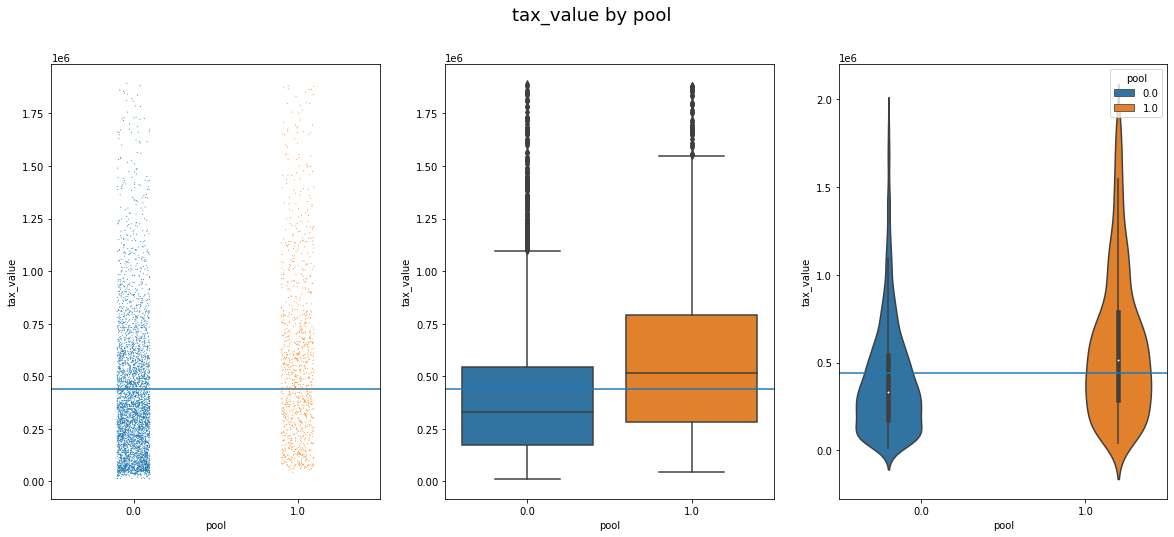

In [34]:
# for county in train.county:
#     print(county)
    # explore.plot_categorical_and_continuous_vars(train[train.county == county], ['bedroom_cat','bathroom_cat','condition'], ['tax_value'], sample_amt = 5000)
explore.plot_categorical_and_continuous_vars(train, ['bedroom_cat','bathroom_cat','county','pool'], ['tax_value'], sample_amt = 5000)

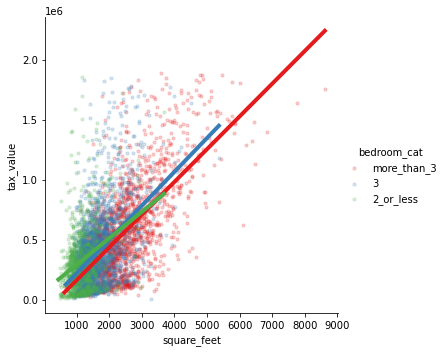

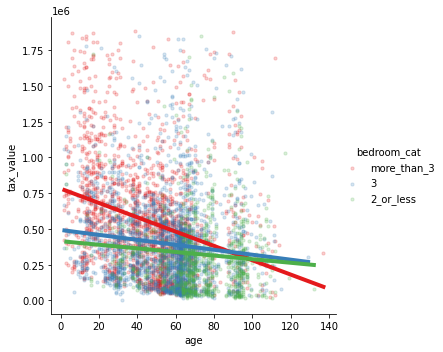

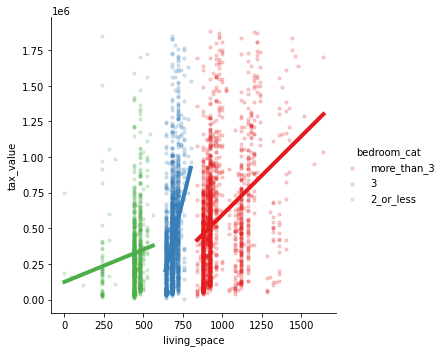

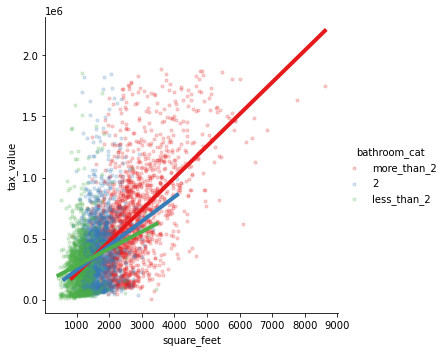

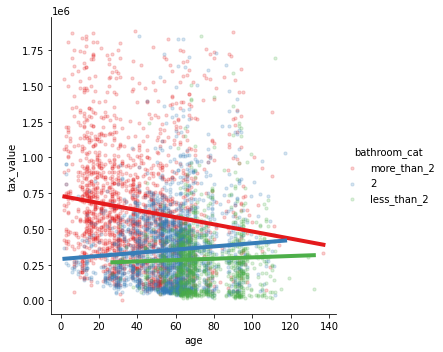

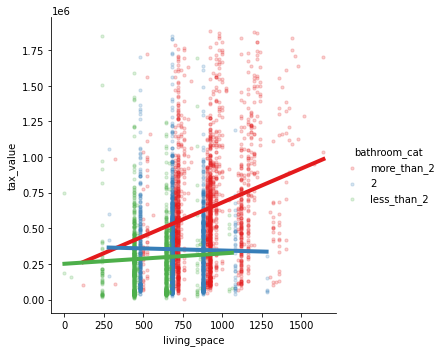

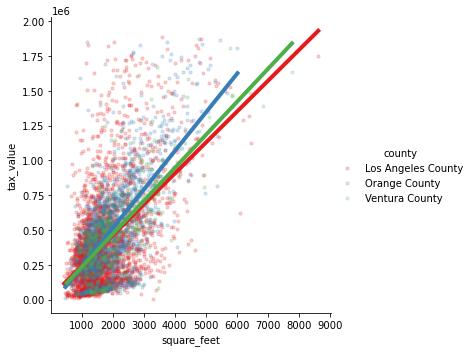

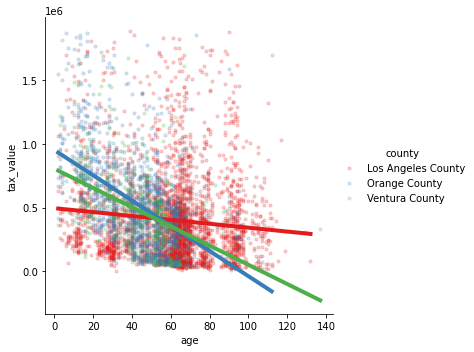

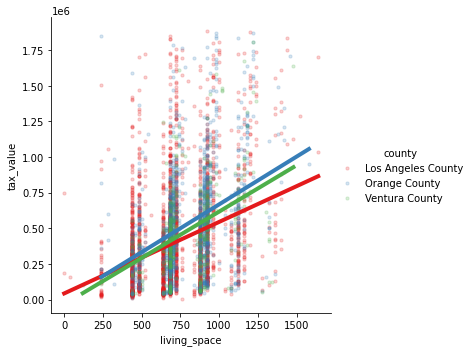

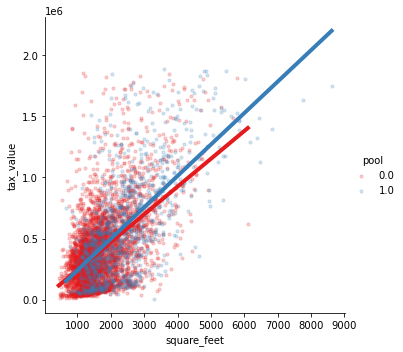

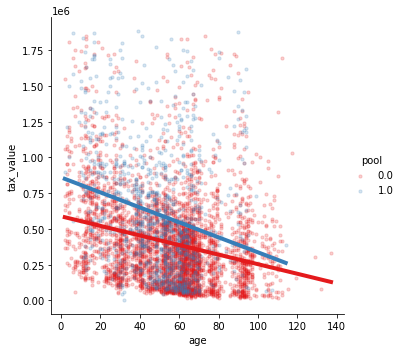

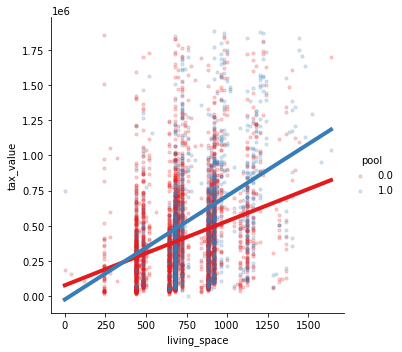

In [35]:
explore.plot_variable_pairs(train, ['square_feet','age','living_space'], categoricals = ['bedroom_cat','bathroom_cat','county','pool'], targets=['tax_value'], sample_amt=5000)

### Takeaways:
- Average tax value looks to be higher than the overall average for more than 3 bedrooms and lower for 3 or less:
    - check with 1 sample t test for all 3 categories
- Average tax value looks to be higher than the overall average for more than 2 bathrooms and lower for 2 or less
    - check with 1 sample t test for all 3 categories
- Seems to be a linear relationship between square feet and tax value
    - check with a correlation test (Pearson)
- Having a garage seems to add value to a home
    - check a 2 sample t test for two categories and a 1 sample test vs overall mean
- The greater the age the lower the value in general
    - check with a correlation test
- The county home is in affects the tax value: LA looks to be less than other two
    - will confirm with 1 sample t test for all 3 counties
- Having a pool seems more valuable than not
    - will confirm with 1 sample t test for both categories
- Bedroom count does not have a great effect on the square feet to tax value relationship
- Bathroom count also does not have a great effect on the square feet to tax value relationship but there is a little more variation in the slope of the lines 

### Statistical tests of tax values depending on bedroom and bathroom count category
- all 1 sample t test to check the category average tax value vs the overall
- will check if significantly higher or lower depending on 2-tailed test result
- assumptions for t-test will be checked prior to performing test -> all categories have >> 30 samples
- $H_0$ for all is that the category average is not significantly different from the overall average
- alpha value is 0.05 for all

In [36]:
alpha = 0.05

### Start with bedroom category

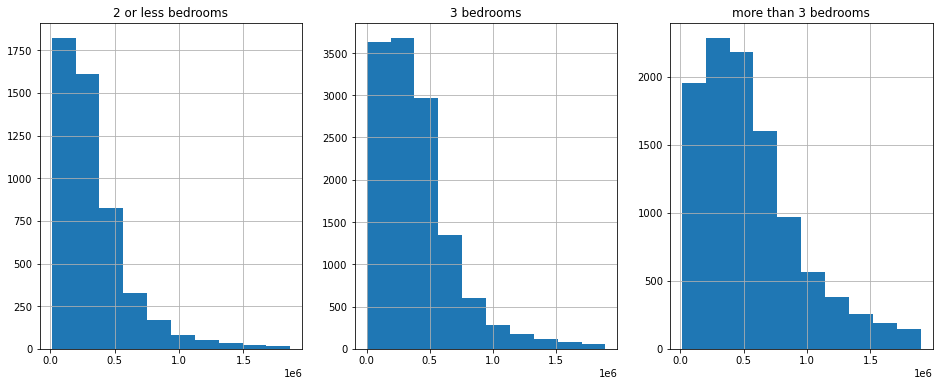

In [37]:
plt.figure(figsize=(16,6))
for i, bed_cat in enumerate(set(train.bedroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bed_cat.replace("_"," ")+" bedrooms")
    train.tax_value[train.bedroom_cat == bed_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [38]:
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bed_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bed_cat in set(train.bedroom_cat):
    sample = train.tax_value[train.bedroom_cat == bed_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(bed_cat, round(t,2), "Significantly Less")

2_or_less -28.37 Significant (2-tail)? True
3 -18.22 Significant (2-tail)? True
more_than_3 29.81 Significant (2-tail)? True
-----------
2_or_less -28.37 Significantly Less
3 -18.22 Significantly Less
more_than_3 29.81 Significantly Greater


### Based on t-test, 3 or fewer bedrooms tax values are significantly less than the average, while more than 3 is signficantly more

In [39]:
# Maybe t test is not applicable given not so normal distributed?
# for bed_cat in set(train.bedroom_cat):
#     sample = train.tax_value[train.bedroom_cat == bed_cat]
#     u, p = stats.wilcoxon(sample, train.tax_value.mean())
#     print(bed_cat, round(u,2), "Significant (2-tail)?", p < alpha)
# print("-----------")
# for bed_cat in set(train.bedroom_cat):
#     sample = train.tax_value[train.bedroom_cat == bed_cat]
#     u, p = stats.wilcoxon(sample, train.tax_value.mean(),alternative='greater')
#     if p/2 < alpha:
#         print(bed_cat, round(u,2), "Significantly Greater")
        
#     u, p = stats.wilcoxon(sample, train.tax_value.mean(),alternative='less')
    
#     if p/2 < alpha:
#         print(bed_cat, round(u,2), "Significantly Less")

### Moving on to bathrooms

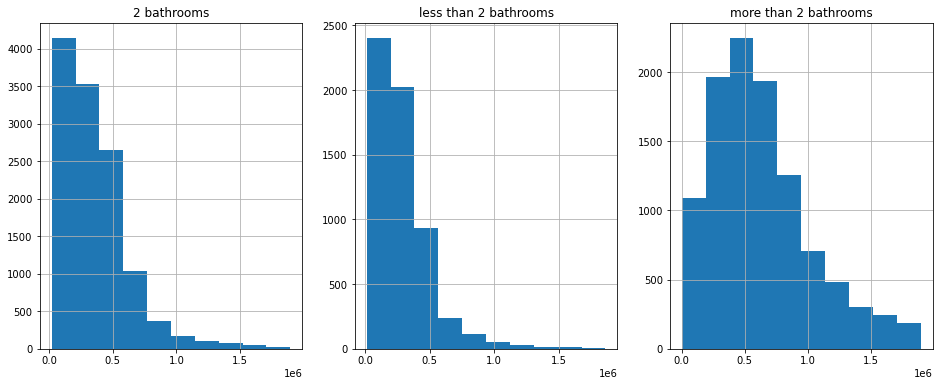

In [40]:
plt.figure(figsize=(16,6))
for i, bath_cat in enumerate(set(train.bathroom_cat)):
    plt.subplot(1, 3, i+1)
    plt.title(bath_cat.replace("_"," ")+" bathrooms")
    train.tax_value[train.bathroom_cat == bath_cat].hist()

### Approximately normal distribution but very much skewed to the left

In [41]:
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(bath_cat, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for bath_cat in set(train.bathroom_cat):
    sample = train.tax_value[train.bathroom_cat == bath_cat]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(bath_cat, round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(bath_cat, round(t,2), "Significantly Less")

2 -34.7 Significant (2-tail)? True
less_than_2 -55.38 Significant (2-tail)? True
more_than_2 49.99 Significant (2-tail)? True
-----------
2 -34.7 Significantly Less
less_than_2 -55.38 Significantly Less
more_than_2 49.99 Significantly Greater


## Based on t-test, 2 or fewer bathrooms have tax values significantly lower than the overall average while greater than 2 bathrooms results in higher than average values

### Check whether having garage or not better for home value

In [42]:
with_garage_sample = train[train.has_garage]
without_garage_sample = train[~train.has_garage]

# check variances
statistic, p = stats.levene(with_garage_sample.tax_value, without_garage_sample.tax_value)

In [43]:
if p<0.05:
    print("Reject null hypothesis - can assume variances are unequal")

Reject null hypothesis - can assume variances are unequal


In [44]:
t, p = stats.ttest_ind(with_garage_sample.tax_value, without_garage_sample.tax_value,equal_var=False)

In [45]:
t,p

(26.82458210228011, 1.0375327783816111e-155)

In [46]:
t, p = stats.ttest_1samp(with_garage_sample.tax_value, train.tax_value.mean())

In [47]:
t,p

(21.601214643612934, 3.8810204144258434e-101)

### Having a garage definitely better than not having one

## Checking counties

In [48]:
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(county, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(county, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(county, round(t,2), "Significantly Less")

Los Angeles County -15.76 Significant (2-tail)? True
Ventura County 6.95 Significant (2-tail)? True
Orange County 19.88 Significant (2-tail)? True
-----------
Los Angeles County -15.76 Significantly Less
Ventura County  t:  6.95 Significantly Greater
Orange County  t:  19.88 Significantly Greater


### Confirm that Orange and Ventura counties have tax values above the overall mean, while LA has lower

### Pools

In [49]:
for pool in set(train.pool):
    sample = train.tax_value[train.pool == pool]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    print(pool, round(t,2), "Significant (2-tail)?", p < alpha)
print("-----------")
for pool in set(train.pool):
    sample = train.tax_value[train.pool == pool]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='greater')
    if p/2 < alpha:
        print(pool, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean(),alternative='less')
    
    if p/2 < alpha:
        print(pool, round(t,2), "Significantly Less")

0.0 -18.23 Significant (2-tail)? True
1.0 28.75 Significant (2-tail)? True
-----------
0.0 -18.23 Significantly Less
1.0  t:  28.75 Significantly Greater


### Confirm having a pool tax value higher than not

### Analyzing correlation between variables

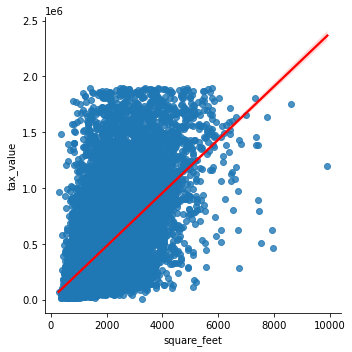

In [50]:
sns.lmplot(data = train, x= 'square_feet', y='tax_value', line_kws={'color':'red'})

### Looks like a fairly linear relationship between square footage and tax value

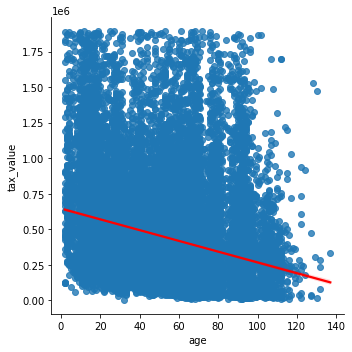

In [51]:
sns.lmplot(data = train, x= 'age', y='tax_value', line_kws={'color':'red'})

### Looks like as age increases tax value decreases

### Does the ratio of bedrooms to bathrooms have any effect on tax value?

In [52]:
# Do have some 0 values for num of bathrooms, so replace these with 0
train["bed_to_bath"] = (train.bedroom/train.bathroom).replace(np.inf, 0).fillna(0)
validate["bed_to_bath"] = (validate.bedroom/validate.bathroom).replace(np.inf, 0).fillna(0)
test["bed_to_bath"] = (test.bedroom/test.bathroom).replace(np.inf, 0).fillna(0)

In [53]:
r, p = stats.pearsonr(train.bed_to_bath, train.tax_value)
print("p<alpha: ", p<alpha, ",correlation: ", r, "weak negative")

p<alpha:  True ,correlation:  -0.3041141907044659 weak negative


## Check correlation of all variables to target

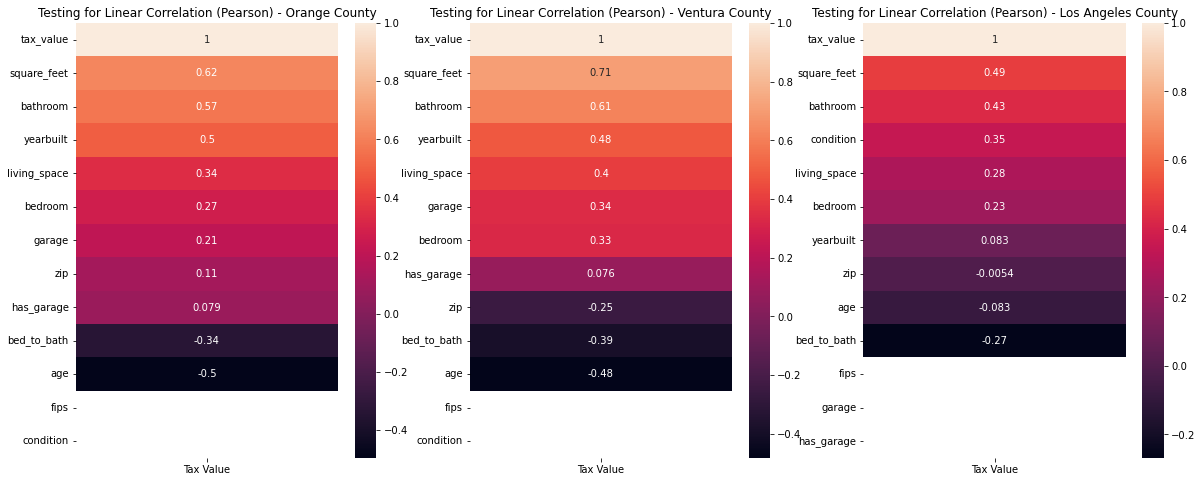

In [250]:
plt.figure(figsize=(20,8))
for i, county in enumerate(set(train.county)):
    sample = train[train.county == county]
    linear_correlation = pd.DataFrame({"Tax Value":sample.corrwith(sample.tax_value,method='pearson')}).sort_values(by='Tax Value',ascending=False)

    non_linear_correlation = pd.DataFrame({"Tax Value":sample.corrwith(sample.tax_value,method='spearman')}).sort_values(by='Tax Value',ascending=False)

    plt.subplot(1, 3, i+1)
    plt.title(f"Testing for Linear Correlation (Pearson) - {county}")
    sns.heatmap(linear_correlation, annot=True)

<AxesSubplot:title={'center':'Testing for Non-Linear Correlation (Spearman)'}>

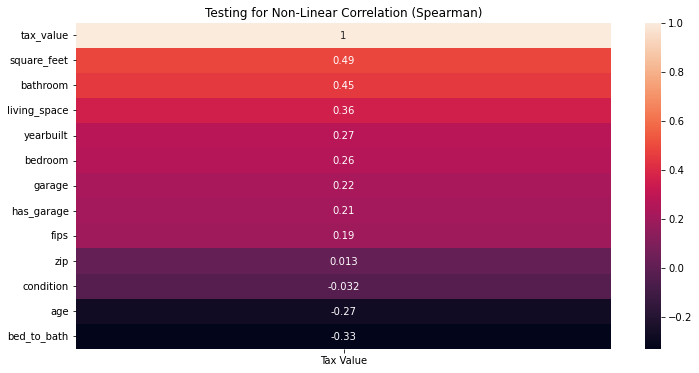

In [177]:
plt.figure(figsize=(12,6))
plt.title("Testing for Non-Linear Correlation (Spearman)")
sns.heatmap(non_linear_correlation, annot=True)

### Takeaways:
- Relatively high correlation with square footage and bathroom count:
    - As these two values increase, home value does as well
- Weak correlation between garage count, bedroom count and tax value
- No variable here has very high correlation - other factors must influence

# Modeling

### Prepare datasets per curriculum

In [178]:
train.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'age', 'county', 'living_space',
       'bedroom_cat', 'bathroom_cat', 'has_garage', 'bed_to_bath'],
      dtype='object')

### Breaking down by fips....location location location

In [179]:
fip_to_test = 6059.0
# train = train[train.fips == fip_to_test]
# validate = validate[validate.fips == fip_to_test]
# test = test[test.fips == fip_to_test]

#### Dummy variables for categoricals

In [180]:
to_dummy = ['bedroom_cat','bathroom_cat','county']

In [181]:
X_train_exp = pd.get_dummies(train, columns = to_dummy, drop_first=True)

In [182]:
X_train_exp.columns

Index(['bedroom', 'bathroom', 'square_feet', 'tax_value', 'fips', 'garage',
       'yearbuilt', 'condition', 'zip', 'age', 'living_space', 'has_garage',
       'bed_to_bath', 'bedroom_cat_3', 'bedroom_cat_more_than_3',
       'bathroom_cat_less_than_2', 'bathroom_cat_more_than_2',
       'county_Orange County', 'county_Ventura County'],
      dtype='object')

In [222]:
# These are the features that will be fed into the model based on exploration
columns_to_use = ['square_feet','age','bedroom_cat_3', 'bedroom_cat_more_than_3',
       'bathroom_cat_less_than_2', 'bathroom_cat_more_than_2',
       'county_Orange County', 'county_Ventura County']

In [223]:
X_train = X_train_exp[columns_to_use]
X_validate = pd.get_dummies(validate, columns = to_dummy, drop_first=True)[columns_to_use]
X_test = pd.get_dummies(test, columns = to_dummy, drop_first=True)[columns_to_use]

In [224]:
X_train.columns

Index(['square_feet', 'age', 'bedroom_cat_3', 'bedroom_cat_more_than_3',
       'bathroom_cat_less_than_2', 'bathroom_cat_more_than_2',
       'county_Orange County', 'county_Ventura County'],
      dtype='object')

In [225]:
features_to_scale = ['square_feet','age']

In [226]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data(X_train, X_validate, X_test,features_to_scale)

In [227]:
y_train = train[['tax_value']]
y_validate = validate[['tax_value']]
y_test = test[['tax_value']]

(array([6753., 7180., 6106., 3486., 1941., 1100.,  644.,  438.,  295.,
         250.]),
 array([1.0000000e+03, 1.7809150e+05, 3.5518300e+05, 5.3227450e+05,
        7.0936600e+05, 8.8645750e+05, 1.0635490e+06, 1.2406405e+06,
        1.4177320e+06, 1.5948235e+06, 1.7719150e+06]),
 <BarContainer object of 10 artists>)

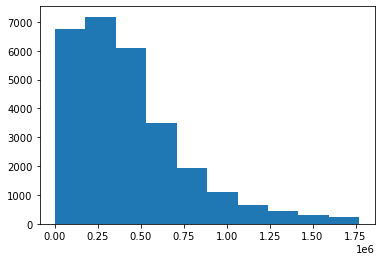

In [228]:
plt.hist(y_train)

In [229]:
# Perform Feature Selection using Recursive Feature Elimination
# Initialize ML algorithm
lm = LinearRegression()
# create RFE object - selects top 3 features only
rfe = RFE(lm, n_features_to_select=3)
# fit the data using RFE
rfe.fit(X_train_scaled, y_train)
# get mask of columns selected
feature_mask = rfe.support_
# get list of column names
rfe_features = X_train_scaled.iloc[:,feature_mask].columns.tolist()
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


,Var,Rank
1,bedroom_cat_more_than_3,1
6,square_feet_scaled,1
7,age_scaled,1
4,county_Orange County,2
0,bedroom_cat_3,3
3,bathroom_cat_more_than_2,4
5,county_Ventura County,5
2,bathroom_cat_less_than_2,6


In [230]:
X_train_scaled = X_train_scaled[rfe_features]
X_validate_scaled = X_validate_scaled[rfe_features]
X_test_scaled = X_test_scaled[rfe_features]

In [231]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
})

## Baseline

In [232]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  331271.11 
Validate/Out-of-Sample:  329024.79
RMSE using Median
Train/In-Sample:  338946.35 
Validate/Out-of-Sample:  336775.66


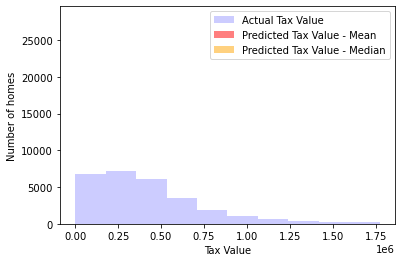

In [233]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.2, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=1171100, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of homes")
plt.legend()
plt.show()


In [234]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  270668.0677011381 
Validation/Out-of-Sample:  271612.37880017055


In [235]:
# create the model object
lars = LassoLars(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using LarsLasso\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for OLS using LarsLasso
Training/In-Sample:  270669.4230706108 
Validation/Out-of-Sample:  271612.1259664232


In [236]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  331271.1122101347 
Validation/Out-of-Sample:  329024.79072827956


### Polynomial Features

In [239]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2,interaction_only=False)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [240]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  264782.7021881434 
Validation/Out-of-Sample:  266115.8131584051


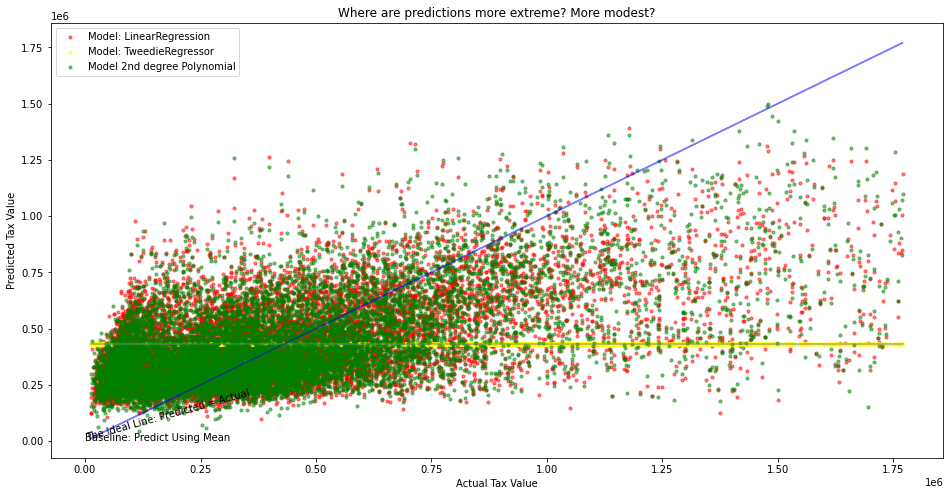

In [241]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=10, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=10, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=10, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


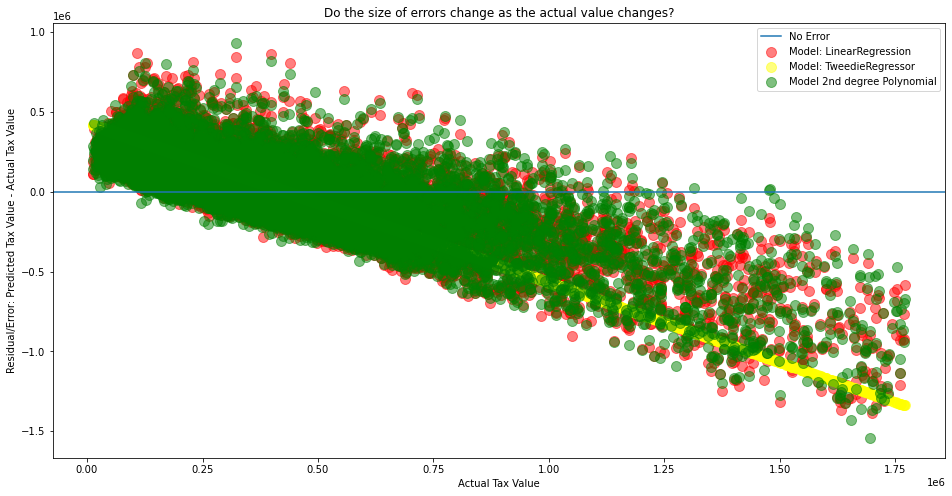

In [242]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

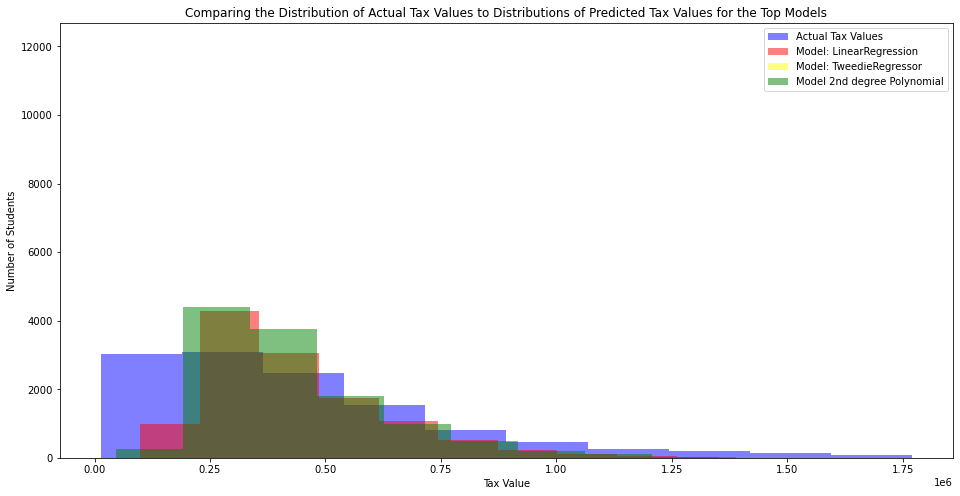

In [243]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()


In [244]:
y_validate

,tax_value,tax_value_pred_mean,tax_value_pred_median,tax_value_pred_lm,tax_value_pred_lars,tax_value_pred_glm,tax_value_pred_lm2
27505,544000.0,431722.238641,360000.0,290526.413615,289936.390400,431722.238641,2.931921e+05
35930,913725.0,431722.238641,360000.0,715909.249078,715149.193847,431722.238641,7.437021e+05
41996,349662.0,431722.238641,360000.0,473768.209000,473633.354721,431722.238641,4.704499e+05
39623,381824.0,431722.238641,360000.0,331252.685800,332769.781925,431722.238641,3.734572e+05
10329,57214.0,431722.238641,360000.0,329263.125741,328990.050533,431722.238641,2.939234e+05
...,...,...,...,...,...,...,...
42638,302873.0,431722.238641,360000.0,469222.541580,468996.059198,431722.238641,5.073366e+05
24058,541000.0,431722.238641,360000.0,430650.220304,430120.890508,431722.238641,3.542854e+05
47567,799877.0,431722.238641,360000.0,701782.751094,701955.696394,431722.238641,6.820276e+05
15345,750628.0,431722.238641,360000.0,991509.498921,990945.505515,431722.238641,1.088935e+06


In [247]:
pd.concat([
    y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(lambda x: x**0.5)
)

,r2,mse,rmse
tax_value,1.000000e+00,0.000000e+00,0.000000
tax_value_pred_mean,-1.215339e-07,1.082573e+11,329024.790728
tax_value_pred_median,-4.766927e-02,1.134178e+11,336775.661291
tax_value_pred_lm,3.185376e-01,7.377328e+10,271612.378800
tax_value_pred_lars,3.185388e-01,7.377315e+10,271612.125966
tax_value_pred_glm,-1.215339e-07,1.082573e+11,329024.790728
tax_value_pred_lm2,3.458397e-01,7.081763e+10,266115.813158


# Predict on Test

In [246]:
# y_test = pd.DataFrame(y_test)

# # predict on test
# y_test['tax_value_pred_lm'] = lm.predict(X_test)

# # evaluate: rmse
# rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

# print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)
